In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load the EfficientNetB0 model, pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [2]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile

<ipython-input-2-36398ed231ac>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_left.jpg  
 

In [4]:
import os

# Path to the main dataset directory
dataset_path = '/content/dataset'

# Recursively list all files and directories
for root, dirs, files in os.walk(dataset_path):
    print(f'Root: {root}')
    print(f'Directories: {dirs}')
    # print(f'Files: {files}')
    # print('-' * 40)

Root: /content/dataset
Directories: ['cataract', 'normal', 'diabetic_retinopathy', 'glaucoma']
Root: /content/dataset/cataract
Directories: []
Root: /content/dataset/normal
Directories: []
Root: /content/dataset/diabetic_retinopathy
Directories: []
Root: /content/dataset/glaucoma
Directories: []


In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Step 1: Set the correct dataset path
dataset_path = '/content/dataset'  # This is the path to the dataset folder

# Step 2: Initialize arrays for storing images and labels
X = []
y = []

# Define the classes (assuming four types of eye diseases)
classes = ['cataract', 'glaucoma', 'normal', 'diabetic_retinopathy']

# Step 3: Loop through each class folder and load images
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)  # Path to each class folder (inside /dataset/)

    for img_name in tqdm(os.listdir(class_path)):  # List all image files in the class folder
        img_path = os.path.join(class_path, img_name)  # Full path to the image
        img = cv2.imread(img_path)  # Read the image

        if img is not None:  # Make sure the image is loaded correctly
            img = cv2.resize(img, (224, 224))  # Resize to VGG16 input size
            X.append(img)  # Add the image to the list
            y.append(i)  # Use class index as label

# Step 4: Convert to NumPy arrays for model input
X = np.array(X)
y = np.array(y)

# Display the shape of X and y
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {y.shape[0]} labels.")


100%|██████████| 1098/1098 [00:02<00:00, 526.61it/s]


Loaded 4217 images with shape (224, 224, 3) and 4217 labels.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# One-hot encode the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (2825, 224, 224, 3)
X_test Shape:  (1392, 224, 224, 3)
y_train Shape:  (2825, 4)
y_test Shape:  (1392, 4)


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Freeze the base layers
base_model.trainable = False

# Build your custom model on top of InceptionV3
def add_custom_layers(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)  # Global average pooling
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)  # Final layer for classes
    return top_model

num_classes = 4  # Assuming 4 classes
custom_model_output = add_custom_layers(base_model, num_classes)

# Create the full model
model = Model(inputs=base_model.input, outputs=custom_model_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)


Epoch 1/30
89/89 [==============================] - 53s 523ms/step - loss: 0.6186 - accuracy: 0.7469 - val_loss: 0.4031 - val_accuracy: 0.8477
Epoch 2/30
89/89 [==============================] - 45s 503ms/step - loss: 0.3987 - accuracy: 0.8520 - val_loss: 0.3516 - val_accuracy: 0.8693
Epoch 3/30
89/89 [==============================] - 44s 499ms/step - loss: 0.3449 - accuracy: 0.8701 - val_loss: 0.2852 - val_accuracy: 0.8779
Epoch 4/30
89/89 [==============================] - 43s 484ms/step - loss: 0.3129 - accuracy: 0.8800 - val_loss: 0.2701 - val_accuracy: 0.9023
Epoch 5/30
89/89 [==============================] - 44s 495ms/step - loss: 0.2762 - accuracy: 0.8920 - val_loss: 0.2627 - val_accuracy: 0.9045
Epoch 6/30
89/89 [==============================] - 44s 492ms/step - loss: 0.2608 - accuracy: 0.9012 - val_loss: 0.2976 - val_accuracy: 0.8865
Epoch 7/30
89/89 [==============================] - 44s 494ms/step - loss: 0.2443 - accuracy: 0.9080 - val_loss: 0.3074 - val_accuracy: 0.8757

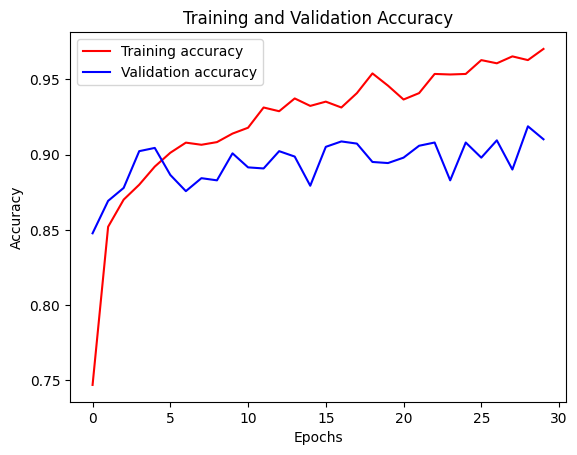

In [8]:
import matplotlib.pyplot as plt

# Check if accuracy and validation accuracy exist
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Accuracy data not found in history.")

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels (one-hot encoded to class labels)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

44/44 [==============================] - 16s 321ms/step


In [10]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true_classes and y_pred_classes are your true and predicted labels, and classes is a list of class names

# Calculate overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score per class (weighted)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print classification report (shows precision, recall, and F1 for each class)
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

# Print overall accuracy, precision, recall, and F1 score
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Accuracy per class (from confusion matrix)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
for i, class_name in enumerate(classes):
    print(f"Accuracy for {class_name}: {class_accuracy[i]:.4f}")

Classification Report:
                       precision    recall  f1-score   support

            cataract       0.90      0.96      0.93       352
            glaucoma       0.90      0.81      0.85       340
              normal       0.86      0.89      0.87       350
diabetic_retinopathy       0.98      0.99      0.98       350

            accuracy                           0.91      1392
           macro avg       0.91      0.91      0.91      1392
        weighted avg       0.91      0.91      0.91      1392

Confusion Matrix:
 [[337  10   5   0]
 [ 20 274  44   2]
 [ 15  20 310   5]
 [  1   0   3 346]]
Overall Accuracy: 0.9102
Weighted Precision: 0.9104
Weighted Recall: 0.9102
Weighted F1 Score: 0.9094
Accuracy for cataract: 0.9574
Accuracy for glaucoma: 0.8059
Accuracy for normal: 0.8857
Accuracy for diabetic_retinopathy: 0.9886
